In [1]:
%pylab notebook
from fontTools import ttLib
from fontTools.pens.basePen import BasePen

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [162]:
tt = ttLib.TTFont("./Lobster-Regular.ttf") # Load an existing font file
# tt = ttLib.TTFont("./RoyalBrand.ttf")
tt.ensureDecompiled()
cmap = tt["cmap"].getBestCmap()
# gs = tt.getGlyphSet()
glyf = tt['glyf']

In [168]:
for c in arange(0x20, 0x20 + 95):
    name = cmap[c]
    print(hex(c), chr(c), name)
    dat = glyf[name].getCoordinates(glyf)
    print(dat)
#     break

0x20   space
(GlyphCoordinates([]), [], bytearray(b''))
0x21 ! exclam
(GlyphCoordinates([(174, 731),(328, 752),(183, 231),(98, 231),(79, -6),(32, 41),(32, 74),(32, 107),(79, 153),(112, 153),(145, 153),(191, 107),(191, 74),(191, 41),(145, -6),(112, -6)]), [3, 15], bytearray(b'\x01\x01\x01\x01\x00\x00\x01\x00\x00\x01\x00\x00\x01\x00\x00\x01'))
0x22 " quotedbl
(GlyphCoordinates([(155, 752),(260, 752),(150, 520),(80, 520),(312, 752),(417, 752),(307, 520),(237, 520)]), [3, 7], bytearray(b'\x01\x01\x01\x01\x01\x01\x01\x01'))
0x23 # numbersign
(GlyphCoordinates([(481, 415),(456, 292),(550, 292),(535, 215),(440, 215),(402, 28),(329, 28),(367, 215),(238, 215),(200, 28),(127, 28),(165, 215),(60, 215),(75, 292),(180, 292),(205, 415),(103, 415),(118, 492),(221, 492),(257, 673),(331, 673),(294, 492),(423, 492),(459, 673),(533, 673),(496, 492),(593, 492),(578, 415),(407, 415),(279, 415),(254, 292),(382, 292)]), [27, 31], bytearray(b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x0

In [97]:
DENSITY = 0.1

def get_points(pt0, pt1, pt2):
    dx = pt2[0] - pt0[0]
    dy = pt2[1] - pt0[1]
    dist = sqrt(dx**2 + dy**2)
    N_POINTS = round(dist * DENSITY)
    if N_POINTS < 3:
        xs = [pt0[0], (pt0[0] + pt2[0]) / 4 + pt1[0] / 2, pt2[0]]
        ys = [pt0[1], (pt0[1] + pt2[1]) / 4 + pt1[1] / 2, pt2[1]]
        return xs, ys

    t = linspace(0, 1, N_POINTS)
    xs = (1 - t)**2 * pt0[0] + 2 * (1 - t) * t * pt1[0] + t**2 * pt2[0]
    ys = (1 - t)**2 * pt0[1] + 2 * (1 - t) * t * pt1[1] + t**2 * pt2[1]
    return xs, ys

<IPython.core.display.Javascript object>


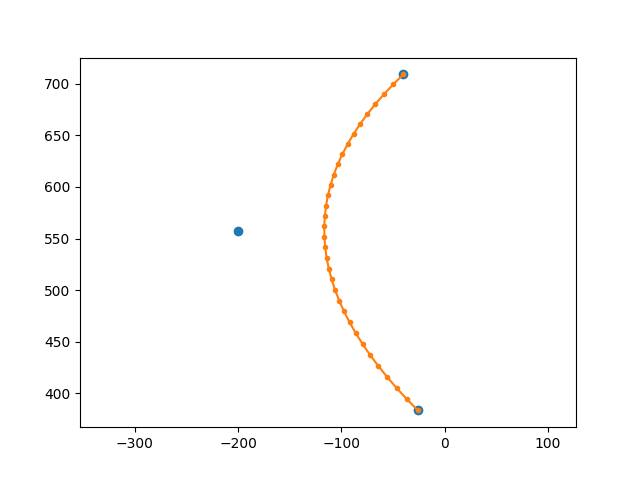

In [98]:
close()
plot()
axis("equal")

pt0, pt1, pt2 = (-26.0, 383.5), (-200, 557), (-40, 709)
plot([pt0[0], pt1[0], pt2[0]], [pt0[1], pt1[1], pt2[1]], 'o')

xs, ys = get_points(pt0, pt1, pt2)
plot(xs, ys, '.-')

In [99]:
class MyPen(BasePen):
    def _lineTo(self, pt):
        print('lineTo', self.last_point, pt)
        plot([self.last_point[0], pt[0]], [self.last_point[1], pt[1]])
        self.last_point = pt
    
    def _moveTo(self, pt):
        print('moveTo', pt)
        self.last_point = pt
        
    def _qCurveToOne(self, pt1, pt2):
        pt0 = self.last_point
        
        dx = pt2[0] - pt0[0]
        dy = pt2[1] - pt0[1]
        dist = sqrt(dx**2 + dy**2)
        N_POINTS = int(dist * DENSITY)
        
        t = linspace(0, 1, N_POINTS)
        
        plot([pt0[0], pt1[0], pt2[0]], [pt0[1], pt1[1], pt2[1]], 'o')

        xs, ys = get_points(pt0, pt1, pt2)
        plot(xs, ys, 'k-')
        
        print('qCurveToOne', pt0, pt1, pt2)
        self.last_point = pt2

mp = MyPen(gs)

In [100]:
g = gs["h"]

In [101]:
g.lsb

-38

In [102]:
g.width

505

In [103]:
gs.hMetrics["h"]

(505, -38)

In [104]:
ggg = gs.glyfTable.glyphs["h"]

<IPython.core.display.Javascript object>


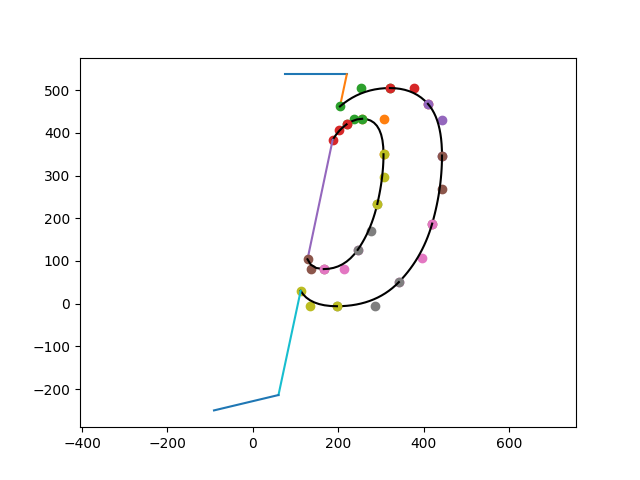

moveTo (76, 537)
lineTo (76, 537) (220, 537)
lineTo (220, 537) (204, 462)
qCurveToOne (204, 462) (254, 505) (321, 505)
qCurveToOne (321, 505) (377, 505) (410.0, 468.0)
qCurveToOne (410.0, 468.0) (443, 431) (443, 347)
qCurveToOne (443, 347) (443, 268) (420.0, 187.5)
qCurveToOne (420.0, 187.5) (397, 107) (342.0, 50.5)
qCurveToOne (342.0, 50.5) (287, -6) (197, -6)
qCurveToOne (197, -6) (133, -6) (112, 30)
lineTo (112, 30) (60, -214)
lineTo (60, -214) (-91, -250)
moveTo (306, 350)
qCurveToOne (306, 350) (306, 433) (256, 433)
qCurveToOne (256, 433) (238, 433) (219.5, 420.0)
qCurveToOne (219.5, 420.0) (201, 407) (187, 384)
lineTo (187, 384) (128, 104)
qCurveToOne (128, 104) (136, 81) (166, 81)
qCurveToOne (166, 81) (214, 81) (245.5, 126.0)
qCurveToOne (245.5, 126.0) (277, 171) (291.5, 233.5)
qCurveToOne (291.5, 233.5) (306, 296) (306, 350)


In [106]:
close()
plot()
axis("equal")
gs["p"].draw(mp)

In [75]:
gk??

In [73]:
gk.coordinates

GlyphCoordinates([(314, -6),(250, 53),(250, 108),(250, 132),(256, 160),(264, 199),(268, 216),(268, 236),(268, 284),(232, 284),(216, 284),(181, 266),(158, 247),(106, 0),(-38, 0),(107, 680),(255, 700),(180, 348),(373, 500),(472, 500),(272, 361),(287, 365),(305, 365),(359, 365),(415, 299),(415, 248),(415, 227),(411, 210),(400, 160),(395, 142),(395, 128),(395, 91),(434, 91),(464, 91),(500, 134),(518, 179),(560, 179),(498, -6),(376, -6)])